# <center>Benchmark découpage</center>

## <center> Introduction</center>

Ce notebook sert à exécuter des commandes `ffmpeg` afin de tester les différents paramètres et d'en tirer rapidement des métriques pour trouver la meilleure façon de découper une vidéo.

Globalement, pour découper une vidéo, on demande à `ffmpeg` d'aller chercher un timestamp, avec l'argument `-ss` pour _seeking_ puis 

- soit aller à un autre timestamp avec l'argument `-to`
- soit recopier une durée déterminée avec l'argument `-t`

Pendant l'opération, on peut soit recopier en dur les flux audio/vidéo sans les décoder, soit réencoder les flux enter les frames de début et de fin. Nous testerons donc :

#### En recopiant le flux vidéo
- l'input seeking : aller de keyframe (frame codée en dur) en keyframe et s'arrêter à la plus proche du timestamp de départ demandé. Sauter de keyframe en keyframe permet d'aller plus vite (d'autant plus qu'il y a peu de keyframes), mais on pert en résolution temporelle (idem). `ffmpeg -ss hh:mm:ss -i $in -to hh:mm:ss -c copy -copyts $out`
- output seeking : le flux d'entrée est décodé __puis__ on le parcourt frame par frame jusqu'à la frame demandée : permet de gagner en précision mais on pert en vitesse : `ffmpeg -i $in -ss hh:mm:ss -to hh:mm:ss -c copy $out`

Lorsque l'on fait des copies sans réencoder le flux vidéo, il est possible que la vidéo d'output ne commence par à 00:00.000 (_i.e._ qu'il y ait un décalage des timestamps). Cela peut se manifester par quelques secondes de noir au début de la vidéo. Dans ce cas, on rajoute le paramètre `-avoid_negative_ts make_zero` :
- en input seeking : `ffmpeg -ss hh:mm:ss -i $in -to hh:mm:ss -c copy -copyts -avoid_negative_ts make_zero $out`
- en output seeking : `ffmpeg -i $in -ss hh:mm:ss -to hh:mm:ss -c copy -avoid_negative_ts make_zero $out`

#### En réencodant le flux vidéo (transcoding)
L'opération sera bien plus longue car on va réencoder le flux pour que :
1. la vidéo de sortie commence exactement au timecode demandé
2. la première frame de cette vidéo (la frame du timecode) soit une keyframe
Ceci permet d'avoir la précision maximale sans artefact, mais cela sera coûteux en temps et en ressources.

- en input seeking : `ffmpeg -ss hh:mm:ss -i $in -to hh:mm:ss -c:v libx264 -c:a aac -copyts $out`
- en output seeking : `ffmpeg -i $in -ss hh:mm:ss -to hh:mm:ss -c:v libx264 -c:a aac $out`

Pour toutes ces commandes, on cherche à benchmark la rapidité, la précision de la découpe et dans le cas du transcodage, une idée qualitative de la qualité visuelle (on aimerait le moins de déformation possible).

Pour paramétrer, donner ci-dessous :
- le chemin vers une vidéo
- le conteneur de sortie (par défaut, .m4v)
- le dossier de sortie des vidéos compressées (par défaut /out inclus dans le dossier courant)
- les commandes à exécuter
- les timestamps de début et de fin, sous forme hh:mm:ss ou somme de secondes en base 10 (par défaut, timestamps aléatoires)

Après l'exécution des commandes, paramétrer les tracés dans la cellule correspondante.

In [26]:
file_in = "/data/bench/cut/2022_CF_Limoges_4nages_dames_200_series1_fixeDroite.mp4"
format_out = ""
destination = "/data/bench/cut"

commands = [
    "ffmpeg -y -ss $begin -i $in -to $end -c copy -copyts $out",   #input seeking
    "ffmpeg -y -i $in -ss $begin -to $end -c copy $out",           #output seeking
    #idem mais on décale les timestamps:
    "ffmpeg -y -ss $begin -i $in -to $end -c copy -copyts -avoid_negative_ts make_zero $out",
    "ffmpeg -y -i $in -ss $begin -to $end -c copy -avoid_negative_ts make_zero $out",
    
    "ffmpeg -y -ss $begin -i $in -to $end -c:v libx264 -c:a aac -copyts $out", #input seeking + transcoding
    "ffmpeg -y -i $in -ss $begin -to $end -c:v libx264 -c:a aac $out", #output seeking + transcoding
    
    "wrapper" #ffmpeg-python package
]

begin_ts = ''
end_ts = ''

## <center>Exécution des commandes</center>

#### Exécution du script

In [32]:
import timeit
import subprocess
import shlex
from datetime import timedelta
import os
import ffmpeg #pip install ffmpeg-python (and not other packages)
from random import uniform

if not format_out: format_out = '.m4v'
if not destination: destination = os.path.join(os.getcwd(), 'out')

Files_durations = [0]*len(commands)
Cut_durations = [0]*len(commands)
f_time = timeit.default_timer

# get the duration of the input video once and for all
file_duration = float(ffmpeg.probe(file_in)["streams"][0]["duration"])
framerate = float(ffmpeg.probe(file_in)["streams"][0]["avg_frame_rate"].split('/')[0])

if not begin_ts: begin_ts = round(uniform(0, file_duration/2), 2) #arbitrarily, in order to have a somehow long video
if not end_ts: end_ts = round(uniform(begin_ts + 1/framerate, file_duration), 2)

extract_duration = end_ts - begin_ts
print("Durée de l'extrait d'entrée :", str(extract_duration), '\n')

for i, command in enumerate(commands):
        file_out = os.path.join(destination, str(i)+format_out)
        print("Commande :", command)
        print("Output :", str(i) + format_out)
        
        open(file_out, 'a').close() # create empty file

        if command != 'wrapper':
            cmd = shlex.split(command.replace("$in", file_in).replace("$out", file_out).replace("$begin", str(begin_ts)).replace("$end", str(end_ts)))
            # renvoie liste ["ffmpeg", "-y", "$in"...]

            #ffmpeg renvoie bcp bcp de texte (essayer dans un terminal), on log que
            #les erreurs qui empêcheraient l'exécution correcte du code
            cmd.append("-loglevel"); cmd.append("error")
            
            c_time0 = f_time()
            subprocess.call(cmd) # execute une commande sous forme de liste (cf. au dessus)
        
        else:  #On teste en dernier le wrapper
            c_time0 = f_time()
            (
                ffmpeg
                .input(file_in, ss = begin_ts, to = end_ts)
                .output(file_out, vcodec='libx264', acodec='aac')
                .global_args("-loglevel", "error")
                .overwrite_output()
                .run()
            )
        
        c_time1 = f_time()
        
        Files_durations[i] = float(ffmpeg.probe(file_out)["streams"][0]["duration"])
        print("Durée du fichier de sortie :", str(Files_durations[i]))
        
        Cut_durations[i] = c_time1 - c_time0
        print("Durée de découpe :", str(timedelta(seconds = Cut_durations[i])))
        print("Par rapport à la durée de la vidéo :", str( Cut_durations[i]/file_duration ))
        print("Par rapport à la durée de l'extrait' :", str( Cut_durations[i]/extract_duration ), '\n')
        
        

Durée de l'extrait d'entrée : 70.29 

Commande : ffmpeg -y -ss $begin -i $in -to $end -c copy -copyts $out
Output : 0.m4v
Durée du fichier de sortie : 74.7
Durée de découpe : 0:00:01.078660
Par rapport à la durée de la vidéo : 0.006471440922727706
Par rapport à la durée de l'extrait' : 0.015345849665674406 

Commande : ffmpeg -y -i $in -ss $begin -to $end -c copy $out
Output : 1.m4v
Durée du fichier de sortie : 69.7
Durée de découpe : 0:00:01.018483
Par rapport à la durée de la vidéo : 0.006110411279096162
Par rapport à la durée de l'extrait' : 0.014489733276422652 

Commande : ffmpeg -y -ss $begin -i $in -to $end -c copy -copyts -avoid_negative_ts make_zero $out
Output : 2.m4v
Durée du fichier de sortie : 74.7
Durée de découpe : 0:00:01.047755
Par rapport à la durée de la vidéo : 0.006286026289897691
Par rapport à la durée de l'extrait' : 0.014906172456966097 

Commande : ffmpeg -y -i $in -ss $begin -to $end -c copy -avoid_negative_ts make_zero $out
Output : 3.m4v
Durée du fichier de 

#### Premières conclusions

La première vidéo met beaucoup de temps à se lancer : la méthode d'input seeking sans décalage est à proscrire. 

On va faire un contrôle qualité des temps de départ des vidéos :

In [96]:
print("Timestamp de démarrage :", begin_ts)
Start_times = [0]*len(commands)

for i in range(len(commands)):
    Start_times[i] = float(ffmpeg.probe(os.path.join(destination, str(i)+format_out))["streams"][0]["start_time"])
    print(i, str(Start_times[i]))

Timestamp de démarrage : 74.36
0 70.0
1 0.64
2 0.047969
3 0.632031
4 74.36
5 0.0
6 0.0


En effet, la première vidéo met `start_time` secondes à se lire une fois le fichier ouvert dans un lecteur classique. Le lecteur est ensuite troublé car `start_time + duration` est inférieur à `duration` (!!) : il n'est même pas possible de naviguer correctement dans la vidéo.

Ensuite, en output seeking, même en décalant les timestamps pour que tous les timestamps de la vidéo soient positifs ou nuls, le flux vidéo commence par une demi seconde bloquée sur la première frame (le flux audio est conservé et semble synchronisé quand on décale pas les timestamps).

#### Paramétrage du tracé des figures

Text(0.5, 1.0, 'Temps de découpe')

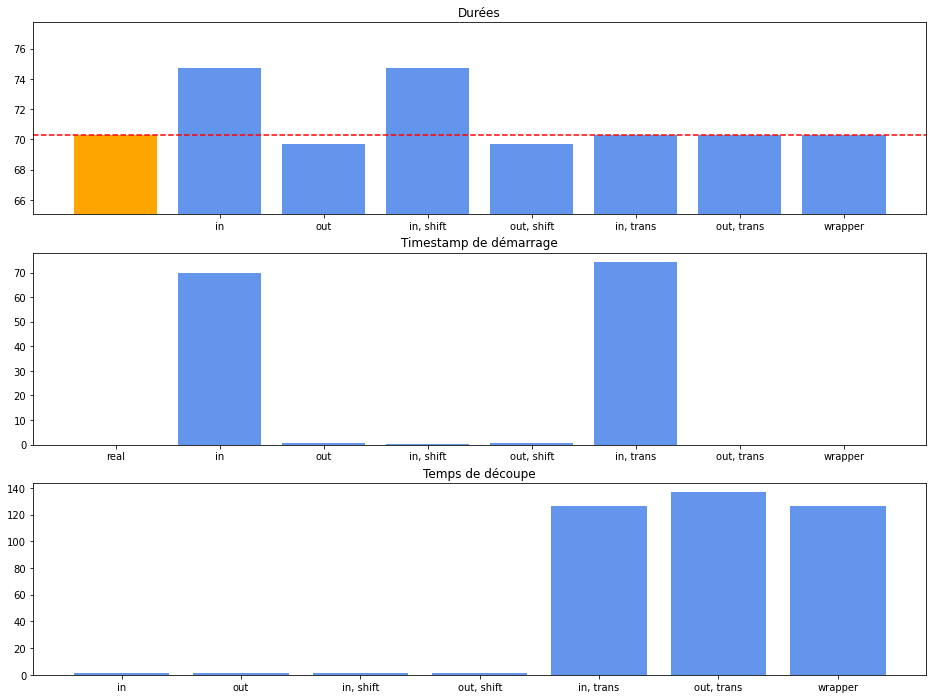

In [122]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

Formats = ['real', 'in', 'out', 'in, shift', 'out, shift', 'in, trans', 'out, trans', 'wrapper']
dur_avg = np.mean(Files_durations)
dur_std = np.std(Files_durations)

mpl.rcParams['figure.figsize'] = [2.5*v for v in mpl.rcParamsDefault['figure.figsize']] # to get bigger figures

fig, (sub1, sub2, sub3) = plt.subplots(3)

sub1.bar(Formats, [extract_duration]+Files_durations, color=['orange']+['cornflowerblue']*(len(Formats)-1))
sub1.set_xticks(Formats)
sub1.axhline(y = extract_duration, color='red', linestyle='--')
sub1.set_ylim(dur_avg-3*dur_std, dur_avg+3*dur_std)
sub1.set_title("Durées")

sub2.bar(Formats, [0.0]+Start_times, color=['orange']+['cornflowerblue']*(len(Formats)-1))
sub1.set_xticks(Formats)
sub2.set_title("Timestamp de démarrage")

sub3.bar(Formats[1:], Cut_durations, color='cornflowerblue')
sub1.set_xticks(Formats[1:])
sub3.set_title("Temps de découpe")

## <center>Conclusion</center>

Pour avoir un extrait découpé correct, c'est-à-dire
- dont le flux vidéo commence au timestamp 0:00.00
- de la bonne durée
- lisible correctement sur les lecteurs habituels (et _a foriori_ exploitable par nos modèles),

il faudra forcément passer par un transcodage. Visuellement, le transcodage n'a pas l'air de déteriorer une fois de plus la qualité visuelle de l'extrait.

Si on veut s'en assurer, on pourra uniquement découper les RAWs et dans ce cas spécifier les paramètres de compression utilisés en paramètre du script de découpage (dans le repo de pré traitement).
